begin jul7 18 2019
i want to make a database of nested trnas, their sequence and their host  intron sequences

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn

In [58]:
merged = pd.read_table('trna_host_genes_merged.csv', sep=',')#only nested trnas 
fb_trna=pd.read_table('complete_trna_info.csv',sep=',')  #all flybase trnas
introns = pd.read_table('host_introns_only.bed',sep=',') ##custom bed wirh host intron IDs

In [3]:
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,A-content,G-content,C-content,T-content,GC-content,AT-content,Length,Co-orientation
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested,0.205479,0.356164,0.232877,0.205479,0.589041,0.438356,73,Non-nested
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889,72,Non-nested
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889,72,Non-nested


In [4]:
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
0,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,49756,4841,caps,+,Yes
1,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,1309,3120,Esyt2,+,Yes
2,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,204807,5167,Ptp61F,-,No
3,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,204807,5167,Ptp61F,-,No
4,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,204807,5167,Ptp61F,-,No


for the trnasequencing analysis, i wrote a script that extracted sequences from fasta using a ID information and sequence location stored in gff table. bedtools requires fasta header with >chr so thats why I had to that

In [5]:
##example of fasta file with intronic regions of host transcript IDs
!head -10 host_transc_introns.fasta

>FBgn0026189_intron_FBgn0026189:16_FBgn0026189:15 type=intron; loc=3L:complement(3120401..3120458); parent=FBgn0026189,FBtr0073118,FBtr0073119,FBtr0073120,FBtr0306258,FBtr0333895,FBtr0337055,FBtr0337056; MD5=c536164cef683e0c151f65a1466d8481; release=r6.28; species=Dmel; length=58; 
GTGAGTTTTGAGACCATTGATTCAATTAACGTAGATAACCAATATTTGTTCACCACAG
>FBgn0053517_intron_FBgn0053517:13_FBgn0053517:12 type=intron; loc=X:complement(20026896..20027750); parent=FBgn0053517,FBtr0343167,FBtr0343168,FBtr0343169,FBtr0343170,FBtr0343171; MD5=f9a10dfb97a95769dd1e8facc2e69c75; release=r6.28; species=Dmel; length=855; 
GTGAGTACGAGGCAGGATTACCATTCGAAATCATCAAACTACTACAACTTAACATCTTAA
AACCGCATTATAAATCTTTAAAAATCATTAAAGCTCATTAGATATTATTGAATATCATTC
AAAGGCTTTAAAATTATTAAATTAGATTAGATAGCCTTGAATCTCATTAAATACCTTTAA
ACATTATCATCAAGTTGGAGCATCATTTAAACCTTGCAACAGCAACTTCTTTAGTATAAT
ATATTTTCATCGGATAGTGAGGTGACTAGGTTTTGAGAACAGAATTCCTTAGATTTCTAA
GATGGGAGTATTTGAATGAAACCGCCGATAATTAATTTATTTATAAAGATGTTCATTTAG
AAATCAGTTTTGATAGCAAGAATTTAATTTA

if transcript_ID in fasta header: 
transcript_ID: [sequenc

In [16]:
trans_ids = merged['Host_Exon_ID'].values
trans_ids[:5]

array(['FBtr0305480', 'FBtr0084647', 'FBtr0310161', 'FBtr0310161',
       'FBtr0310161'], dtype=object)

In [13]:
fas = []
with open('host_transc_introns.fasta', 'r') as f:
    for line in f:
        fas.append(line.rstrip())
fas[0]

'>FBgn0026189_intron_FBgn0026189:16_FBgn0026189:15 type=intron; loc=3L:complement(3120401..3120458); parent=FBgn0026189,FBtr0073118,FBtr0073119,FBtr0073120,FBtr0306258,FBtr0333895,FBtr0337055,FBtr0337056; MD5=c536164cef683e0c151f65a1466d8481; release=r6.28; species=Dmel; length=58;'

In [31]:
fas[1]

'GTGAGTTTTGAGACCATTGATTCAATTAACGTAGATAACCAATATTTGTTCACCACAG'

In [14]:
len(fas)

37752

In [20]:
introns.head()

,Chr,Start,End,ExonID,Score,Strand,Length
0,chr3R,24555133,24555458,FBtr0084647_intron_7_0_chr3R_24555134_f,0,+,325
1,chr3R,16315246,16321962,FBtr0334699_intron_7_0_chr3R_16315247_r,0,-,6716
2,chr3R,5385862,5392786,FBtr0078800_intron_9_0_chr3R_5385863_r,0,-,6924
3,chr3R,8842839,8864785,FBtr0305301_intron_10_0_chr3R_8842840_r,0,-,21946
4,chr3R,10264878,10291099,FBtr0305356_intron_0_0_chr3R_10264879_f,0,+,26221


In [25]:
##check for a sample FBtr0084647 in fasta fromt he above bed file
for line in fas:
    if 'FBtr0084647'in line:
        print(line)

>FBgn0266758_intron_FBgn0039208:1_FBgn0039208:5 type=intron; loc=3R:24545070..24551328; parent=FBgn0266758,FBtr0084647; MD5=f0732e3bb7ef2d85dbb440aebea55e42; release=r6.28; species=Dmel; length=6259;
>FBgn0266758_intron_FBgn0039208:5_FBgn0039208:6 type=intron; loc=3R:24551813..24551873; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024,FBtr0334336; MD5=4f26a9e5b5e62d3787df638164f532db; release=r6.28; species=Dmel; length=61;
>FBgn0266758_intron_FBgn0039208:14_FBgn0039208:16 type=intron; loc=3R:24555963..24556235; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024; MD5=7c37b86b3d4c8d131a2d629938ec6d55; release=r6.28; species=Dmel; length=273;
>FBgn0266758_intron_FBgn0039208:8_FBgn0039208:11 type=intron; loc=3R:24552984..24554355; parent=FBgn0266758,FBtr0084647,FBtr0084648; MD5=8ea9b36726c7f75ecd75d36ea91a86e7; release=r6.28; species=Dmel; length=1372;
>FBgn0266758_intron_FBgn0039208:11_FBgn0039208:12 type=intron; loc=3R:24554405..24554464; parent=FBgn0266758,FBtr0084647,FBtr008

In [32]:
##search for location and transcript
for line in fas:
    if 'FBtr0084647'in line:
        if "24555134" in line and "24555458" in line:
            print(line, fas[fas.index(line)+1])
            break
    else:
        continue
##so its correct but i need full sequence

>FBgn0266758_intron_FBgn0039208:13_FBgn0039208:14 type=intron; loc=3R:24555134..24555458; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024; MD5=eb2c05e3e6b2eb5a6973667d53743ba3; release=r6.28; species=Dmel; length=325; GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACGTAGAATGTGACTAT


In [34]:
fas.index(line)

33185

In [37]:
fas[33186:33200]

['GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACGTAGAATGTGACTAT',
 'AGAGAATCTCATAAAAAGTTACAAAGATAGGTCCTTTCAGAACCATACAGAAACTAACTA',
 'CGACCACATCCTCTATAAGAATTAGTTTTTGCTCGAATATTTTCAACGTCCTCGATAGTA',
 'TAGTGGTTAGTATCCCCGCCTGTCACGCGGGAGACCGGGGTTCAATTCCCCGTCGGGGAG',
 'AATCTGTGATTCTTTTTTTTTTTCTTTTACTTTGTTATATAAACAATTTTTGTTTTAATT',
 'GAATCTAATTTGCCATTGCTTTTAG',
 '>FBgn0041092_intron_FBgn0041092:13_FBgn0041092:14 type=intron; loc=2L:9243179..9243234; parent=FBgn0041092,FBtr0303870,FBtr0303871,FBtr0303872,FBtr0303873,FBtr0333405; MD5=5da9f4ca9a0103efc1521fcd3c8c7ae7; release=r6.28; species=Dmel; length=56;',
 'GTATGCTGATTATGAATATGTCATTGATAATCTAATGATGAATTTTGGATTTGTAG',
 '>FBgn0014135_intron_FBgn0014135:4_FBgn0014135:1 type=intron; loc=3R:complement(19794337..19796213); parent=FBgn0014135,FBtr0083795; MD5=5d31c958f233bfc4c10736c3adbcb759; release=r6.28; species=Dmel; length=1877;',
 'GTGAGTTTCCCATGAGCAAATTCTAAGCTAACCCTTCATCTGTTTCTCACAAACAAACGA',
 'TATTTACGTAGAGATTTTCTAAATTTGATTAAAATTTTCAAAATTTATACA

modify the bedfile by adding 1 to the starts coords

In [28]:
introns['Start']=introns['Start']+1
introns.head()

,Chr,Start,End,ExonID,Score,Strand,Length
0,chr3R,24555134,24555458,FBtr0084647_intron_7_0_chr3R_24555134_f,0,+,325
1,chr3R,16315247,16321962,FBtr0334699_intron_7_0_chr3R_16315247_r,0,-,6716
2,chr3R,5385863,5392786,FBtr0078800_intron_9_0_chr3R_5385863_r,0,-,6924
3,chr3R,8842840,8864785,FBtr0305301_intron_10_0_chr3R_8842840_r,0,-,21946
4,chr3R,10264879,10291099,FBtr0305356_intron_0_0_chr3R_10264879_f,0,+,26221


In [54]:
##why did flybase construct a fasta file with a \n with the same sequence!!
fasta = []
file=[]
with open('host_transc_introns.fasta', 'r') as f:
    for line in f:
        file.append(line.strip())
            
    for i in range(len(file)):
        line = file[i]
        if line.startswith('>') is True:
            header =(line.rstrip())
            seq = ""
            j=i  #the index for the sequence
            while True:
                j+=1  #the sequence is one position right of the header line
                if j==len(file):
                    break
                if file[j].startswith('>') is True:
                    break  #when it encounters another header
                else:
                    s = file[j]
                    seq+=s
            fasta.append(header)
            fasta.append(seq)
        else:
            continue
fasta[0:2]

['>FBgn0026189_intron_FBgn0026189:16_FBgn0026189:15 type=intron; loc=3L:complement(3120401..3120458); parent=FBgn0026189,FBtr0073118,FBtr0073119,FBtr0073120,FBtr0306258,FBtr0333895,FBtr0337055,FBtr0337056; MD5=c536164cef683e0c151f65a1466d8481; release=r6.28; species=Dmel; length=58;',
 'GTGAGTTTTGAGACCATTGATTCAATTAACGTAGATAACCAATATTTGTTCACCACAG']

In [57]:
##re-run the test, should show a sequence that is 352ntlong
##search for location and transcript
for line in fasta:
    if 'FBtr0084647'in line:
        if "24555134" in line and "24555458" in line:
            print(line, fasta[fasta.index(line)+1],
                  'length is {}'.format(len(fasta[fasta.index(line)+1])))
            break
    else:
        continue

>FBgn0266758_intron_FBgn0039208:13_FBgn0039208:14 type=intron; loc=3R:24555134..24555458; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024; MD5=eb2c05e3e6b2eb5a6973667d53743ba3; release=r6.28; species=Dmel; length=325; GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACGTAGAATGTGACTATAGAGAATCTCATAAAAAGTTACAAAGATAGGTCCTTTCAGAACCATACAGAAACTAACTACGACCACATCCTCTATAAGAATTAGTTTTTGCTCGAATATTTTCAACGTCCTCGATAGTATAGTGGTTAGTATCCCCGCCTGTCACGCGGGAGACCGGGGTTCAATTCCCCGTCGGGGAGAATCTGTGATTCTTTTTTTTTTTCTTTTACTTTGTTATATAAACAATTTTTGTTTTAATTGAATCTAATTTGCCATTGCTTTTAG length is 325


In [71]:
for line in fasta:
    if 'FBtr0084647'in line:
        if "24555134..24555458" in line:
            print(line, fasta[fasta.index(line)+1],
                  'length is {}'.format(len(fasta[fasta.index(line)+1])))
            break
    else:
        continue

>FBgn0266758_intron_FBgn0039208:13_FBgn0039208:14 type=intron; loc=3R:24555134..24555458; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024; MD5=eb2c05e3e6b2eb5a6973667d53743ba3; release=r6.28; species=Dmel; length=325; GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACGTAGAATGTGACTATAGAGAATCTCATAAAAAGTTACAAAGATAGGTCCTTTCAGAACCATACAGAAACTAACTACGACCACATCCTCTATAAGAATTAGTTTTTGCTCGAATATTTTCAACGTCCTCGATAGTATAGTGGTTAGTATCCCCGCCTGTCACGCGGGAGACCGGGGTTCAATTCCCCGTCGGGGAGAATCTGTGATTCTTTTTTTTTTTCTTTTACTTTGTTATATAAACAATTTTTGTTTTAATTGAATCTAATTTGCCATTGCTTTTAG length is 325


#### There is no file Rhondene cannot parse. None.

- write this to a proper fasta file with \n only separating only headers and sequence as the good Lord intended

In [58]:
with open('host_transc_introns_V2.fasta', 'w') as f:
    for line in fasta:
        f.write(line+'\n')

In [60]:
! head -2 host_transc_introns_V2.fasta

>FBgn0026189_intron_FBgn0026189:16_FBgn0026189:15 type=intron; loc=3L:complement(3120401..3120458); parent=FBgn0026189,FBtr0073118,FBtr0073119,FBtr0073120,FBtr0306258,FBtr0333895,FBtr0337055,FBtr0337056; MD5=c536164cef683e0c151f65a1466d8481; release=r6.28; species=Dmel; length=58;
GTGAGTTTTGAGACCATTGATTCAATTAACGTAGATAACCAATATTTGTTCACCACAG


In [62]:
len(fasta)

966

write a functiom extract the header and sequence of the specific host intron

In [63]:
str(123)

'123'

In [64]:
introns.head()

,Chr,Start,End,ExonID,Score,Strand,Length
0,chr3R,24555134,24555458,FBtr0084647_intron_7_0_chr3R_24555134_f,0,+,325
1,chr3R,16315247,16321962,FBtr0334699_intron_7_0_chr3R_16315247_r,0,-,6716
2,chr3R,5385863,5392786,FBtr0078800_intron_9_0_chr3R_5385863_r,0,-,6924
3,chr3R,8842840,8864785,FBtr0305301_intron_10_0_chr3R_8842840_r,0,-,21946
4,chr3R,10264879,10291099,FBtr0305356_intron_0_0_chr3R_10264879_f,0,+,26221


In [68]:
IDs = []
for name in introns['ExonID'].values:
    n = name.split('_')[0]
    IDs.append(n)
introns['Transcript_ID']=IDs

In [69]:
introns.head()

,Chr,Start,End,ExonID,Score,Strand,Length,Transcript_ID
0,chr3R,24555134,24555458,FBtr0084647_intron_7_0_chr3R_24555134_f,0,+,325,FBtr0084647
1,chr3R,16315247,16321962,FBtr0334699_intron_7_0_chr3R_16315247_r,0,-,6716,FBtr0334699
2,chr3R,5385863,5392786,FBtr0078800_intron_9_0_chr3R_5385863_r,0,-,6924,FBtr0078800
3,chr3R,8842840,8864785,FBtr0305301_intron_10_0_chr3R_8842840_r,0,-,21946,FBtr0305301
4,chr3R,10264879,10291099,FBtr0305356_intron_0_0_chr3R_10264879_f,0,+,26221,FBtr0305356


In [70]:
introns.to_csv('host_introns_only.bed',sep='\t',index=False)

In [83]:
host_seqs=[]
for i in range(introns.shape[0]):
    trans = introns['Transcript_ID'].values[i]
    start = str(introns['Start'].values[i])
    end = str(introns['End'].values[i])

    for line in fasta:
        if trans in line:
            if start+'..'+end in line:  ##"loc=(start..end)"
                seq = fasta[fasta.index(line)+1]
                entry = [trans,seq]
                host_seqs.append(entry)
                break
    else:
        continue

In [84]:
len(host_seqs)==introns.shape[0]

False

In [80]:
introns.shape ##oh cuz the introns table have the extra pseudo threonine that I omiited

(131, 8)

In [82]:
len(introns['Transcript_ID'].unique())

66

In [88]:
for i in introns['Transcript_ID'].values:
    if i not in merged['Host_Exon_ID'].values:
        print(i)

FBtr0331824


In [85]:
len(host_seqs)

130

In [87]:
host_seqs[0]

['FBtr0084647',
 'GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACGTAGAATGTGACTATAGAGAATCTCATAAAAAGTTACAAAGATAGGTCCTTTCAGAACCATACAGAAACTAACTACGACCACATCCTCTATAAGAATTAGTTTTTGCTCGAATATTTTCAACGTCCTCGATAGTATAGTGGTTAGTATCCCCGCCTGTCACGCGGGAGACCGGGGTTCAATTCCCCGTCGGGGAGAATCTGTGATTCTTTTTTTTTTTCTTTTACTTTGTTATATAAACAATTTTTGTTTTAATTGAATCTAATTTGCCATTGCTTTTAG']

In [89]:
introns = introns[introns['Transcript_ID']!='FBtr0331824']
introns.shape

(130, 8)

In [91]:
d = pd.DataFrame(host_seqs) ##add teh sequences to the tables
d.columns=['Transcript_ID', 'Sequence']
d.head()

,Transcript_ID,Sequence
0,FBtr0084647,GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACG...
1,FBtr0334699,GTAGGTGCGAGTCCAGGACGAAGATTCTGGCATGCCGCTGATCTAG...
2,FBtr0078800,GTACGTGCGCGCATGCGTGTGTGTCTGTGTGTGGGCAAATGCGAGC...
3,FBtr0305301,GTAAGTACAATGATTTATGCAAAGAAAATATACGTATTTCCATGGA...
4,FBtr0305356,GTAAGTGCGTGTAATGCGTGTACGTGTGTGTGTGTGTATGGGTCTG...


In [93]:
merged['Host_Exon_ID'].values==d['Transcript_ID'].values  ##should sort by IDs

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [96]:
merged.sort_values(by='Host_Exon_ID',inplace=True)

In [97]:
d.sort_values(by='Transcript_ID',inplace =True)

In [98]:
merged['Host_Exon_ID'].values==d['Transcript_ID'].values ##good

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [99]:
merged['Intron_Sequence']=d['Sequence'].values
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation,Intron_Sequence
129,2R,21181284,21181355,+,FBgn0053539,Trp-CCA-2-5-,FBtr0071578,3816,1625,Pu,+,Yes,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...
106,3L,3096891,3096963,-,FBgn0052272,Lys-CTT-1-13-,FBtr0073124,2776,3953,Cht7,-,Yes,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
108,3L,3097519,3097590,+,FBgn0052286,Cys-GCA-1-4-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
109,3L,3096369,3096440,+,FBgn0052287,Cys-GCA-1-3-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
110,3L,3095737,3095808,+,FBgn0052288,Cys-GCA-1-1-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...


In [101]:
d.head()

,Transcript_ID,Sequence
102,FBtr0071578,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...
40,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
39,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
42,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
36,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...


In [102]:
introns = introns.sort_values(by='Transcript_ID')
introns['Sequence']=d['Sequence'].values
introns.head()

,Chr,Start,End,ExonID,Score,Strand,Length,Transcript_ID,Sequence
103,chr2R,21180148,21181419,FBtr0071578_intron_1_0_chr2R_21180148_f,0,+,1272,FBtr0071578,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...
41,chr3L,3094887,3097662,FBtr0073124_intron_5_0_chr3L_3094887_r,0,-,2776,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
40,chr3L,3094887,3097662,FBtr0073124_intron_5_0_chr3L_3094887_r,0,-,2776,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
43,chr3L,3094887,3097662,FBtr0073124_intron_5_0_chr3L_3094887_r,0,-,2776,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
37,chr3L,3094887,3097662,FBtr0073124_intron_5_0_chr3L_3094887_r,0,-,2776,FBtr0073124,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...


In [104]:
##save updated tables
merged.to_csv('trna_host_genes_merged.csv', sep=',',index=False)#only nested trnas 
introns.to_csv('host_introns_only_V2.bed',sep=',',index=False) ##custom bed wirh host intron IDs

# Obtain and compare other introns to host

In [2]:
merged = pd.read_table('trna_host_genes_merged.csv', sep=',')#only nested trnas 
fb_trna=pd.read_table('complete_trna_info.csv',sep=',')  #all flybase trnas
introns = pd.read_table('host_introns_only_V2.bed',sep=',') ##custom bed wirh host intron IDs

In [3]:
fasta=[]
with open('host_transc_introns_V2.fasta', 'r') as f:  ##all introns of host genes
    for line in f:
        fasta.append(line.rstrip())
fasta[:2]

['>FBgn0026189_intron_FBgn0026189:16_FBgn0026189:15 type=intron; loc=3L:complement(3120401..3120458); parent=FBgn0026189,FBtr0073118,FBtr0073119,FBtr0073120,FBtr0306258,FBtr0333895,FBtr0337055,FBtr0337056; MD5=c536164cef683e0c151f65a1466d8481; release=r6.28; species=Dmel; length=58;',
 'GTGAGTTTTGAGACCATTGATTCAATTAACGTAGATAACCAATATTTGTTCACCACAG']

In [5]:
for line in fasta:
    if 'FBtr0084647'in line:
        print(line)

>FBgn0266758_intron_FBgn0039208:1_FBgn0039208:5 type=intron; loc=3R:24545070..24551328; parent=FBgn0266758,FBtr0084647; MD5=f0732e3bb7ef2d85dbb440aebea55e42; release=r6.28; species=Dmel; length=6259;
>FBgn0266758_intron_FBgn0039208:5_FBgn0039208:6 type=intron; loc=3R:24551813..24551873; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024,FBtr0334336; MD5=4f26a9e5b5e62d3787df638164f532db; release=r6.28; species=Dmel; length=61;
>FBgn0266758_intron_FBgn0039208:14_FBgn0039208:16 type=intron; loc=3R:24555963..24556235; parent=FBgn0266758,FBtr0084647,FBtr0084648,FBtr0306024; MD5=7c37b86b3d4c8d131a2d629938ec6d55; release=r6.28; species=Dmel; length=273;
>FBgn0266758_intron_FBgn0039208:8_FBgn0039208:11 type=intron; loc=3R:24552984..24554355; parent=FBgn0266758,FBtr0084647,FBtr0084648; MD5=8ea9b36726c7f75ecd75d36ea91a86e7; release=r6.28; species=Dmel; length=1372;
>FBgn0266758_intron_FBgn0039208:11_FBgn0039208:12 type=intron; loc=3R:24554405..24554464; parent=FBgn0266758,FBtr0084647,FBtr008

In [ ]:
#number of introns, lengths, composition

In [13]:
def base_comp(seqs,base):
    """computes base/nucleotide composition
    Input: 
    seqs: array or list of sequences
    base: char, nucleotide A,C,G, or T
    Output: returns list of base compoisiton"""
    content = []
    for seq in seqs:
        fraction = seq.upper().replace('U','T').count(base.upper())/len(seq)  ##replace U with T
        content.append(fraction)
    assert len(content) == len(seqs)
    return content

In [ ]:
bases = ['A','G','C','T']

In [9]:
##extract all intronic sequecnes execpt host intron for parent gene
non_hosts = []
for i in range(introns.shape[0]):
    trans = introns['Transcript_ID'].values[i]
    start = str(introns['Start'].values[i])
    end = str(introns['End'].values[i])
    c = 0
    entry=[trans]
    seqs=[]
    for line in fasta:
        if trans in line:
            c+=1  ##counting number of introns
            if start+'..'+end in line:  ##"loc=(start..end)" skipover host intron information
                continue
            else:
                s = fasta[fasta.index(line)+1]
                seqs.append(s)     
    entry.append(c)
    entry.append(seqs) 
    non_hosts.append(entry)
    continue
##pretty fast

In [10]:
len(non_hosts)

130

In [12]:
non_hosts[2]

['FBtr0073124',
 7,
 ['GTGAGTTGGGACAACTACTCAATAAGTCGTGGATAACGCGTTACTTACACAATTCGTTCTTCATCAACAG',
  'GTGAGTGTCAATATATGCCGATATGAAAAGTTCAATCTATAAATTCTTCCCCAACTTTCTTCAG',
  'GTAAGTTGCTAGAACGGCTTAGCCATGGAACTTTGAATATATACCCATCATTTTGATCAG',
  'GTGAGTGCAAATGTGTGTCAGAGGCATGGAGCTATGGAAATTATCATATCCACAACAGACCCCAACACAGCCCCCTTGGGTTGCCAGAACCAAAAGCATGCCAAAGAATATTGAAAGTCCGTTGACGCAACGGAAAAACGAATGTTAAACAGCAGAAACTCCATGGCAGTTGGAGAACGTAAACTAAGAATGCACAGCGAAAAAAACAAGACAATGCTGCATAAACATAACATAAAACAATGATAGGCAGAAAACAATCAAAGAAATATTATAGACAATTCCAAGATATTTTAGAAAACACTTGATTGTTATTCTTGTTATGCTAATTGTTAAGTTTGCTTTAATTAACCAGCTAACACGTTCTCCGCACAGCTAGGAAATCGTTCAAAATTCTTTTCCTGTGTAAGACTTTATCGCTGAATGGCTGAGTGTGAGAAAAAGCAACAGCAACAACGACAACGGGTTCTGTACCGCTACTGACCGACCGAAGTTGAAGGCGAACTTGTCAAAGACAATGAATAAAATGAGCGCTGAGGGGCTAAACAAAAAAAAAAAATAAATAAAAAAAAGAGTGTAAAGTGGGGGGCTAGAAGTTGGTGGGGGGTTTCAGTTTCGCTTTCGTAGCTGAAAGCCCGTCCGAGAAAAGGGGAAAATGTCCGTAGTCGCAGTCTTCAATTGGCCAATTGGCAACGGCTTTTACTTCCTCGGCCGTTTGAGGCGAAAAGCGAAAAACGAAAAGCCAGCTAGCCGAAAGATTTCCATTAT

### maybe I should store the host introns too

In [14]:
##extract all intronic sequecnes execpt host intron for parent gene
hosts = []
for i in range(introns.shape[0]):
    trans = introns['Transcript_ID'].values[i]
    start = str(introns['Start'].values[i])
    end = str(introns['End'].values[i])
    c = 0
    
    entry=[trans]
    seqs=[]
    
    for line in fasta:
        if trans in line:
            c+=1  ##counting number of introns
            if start+'..'+end in line:  ##"loc=(start..end)" skipover host intron information
                h = fasta[fasta.index(line)+1] ##host
                continue
            else:
                s = fasta[fasta.index(line)+1]
                seqs.append(s)
    ##preprend the host sequence to start of list
    seqs.insert(0,h)
    ##store the number of introns
    entry.append(c)
    entry.append(seqs) 
    hosts.append(entry)
    continue
##very hast

In [16]:
len(hosts)

130

In [18]:
hosts[0]

['FBtr0071578',
 4,
 ['GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATCGAAGTTGCTCATCCTGGTTTTCCCAGCGAGTGGGAACTAGTTTCATGTCGGTGAATCACCATTTACGGGGGTTCCTCGGTCCGCTATGGTGCATTAGCCTAATTACCTGACCACTCGAGAGATAAAGCACATGAACATAGGGAGCCATTAGGCAATTTCGGGCTTGTCCAATCAAGTGGACGCATCCAAAATCCATTCAATATCCTATGAAATATGAGATTTGACTAGTAAAGTTTTTGGTCTCATGTTTGGCGTGCATTTCGACTTGCAGTCGCTTTTGAACTTGTCATGTAATCAATGTGAGTCGTTTGAGAAACAAAACAGAATTGCGAATTATATGGTTGCTACACCAGCATACCTAACCGGTTGCCCGAGAAATCAGGTTCTACGGTTTGTCAAATAAAATCGCATGTAAATTTAAGATCAACAGCAACAGCAGCAGGCCATTTGAAAGCTAAATTCGTTGAACGAAAGTGAATAGCCTTCGGCATCGGCAATAGAATGGGTTGGATTGTGTTTAACCCGAATTCAAAGAACCCAAGAAGCCGAGCCAACGTGACTTGCCAATCTGGTGTTGGGGGAACTCCACCCCCCTCCCCACCACACACACAAGATGCTTGTTGGATTGTTTGTTAGATGGCTCACTGGCTACTTGGCTACTTCTTGGCTTCTTCGCTGGTTGGTCAGGAAACGCACTGAAGCTTTCCGGTCTGTATATTAAGAGCGGTAAAGTGGGTGGGTGTGCGGTGCGGCGGCGGCTTCTATTCAAGGAATGGGAATCTCAAGAGCACATCGTTTAAAACGAGTGTGGCGAAAGCTCACACTCCACAAGAACCATAAGCCCATCCAGTCAAGTCAAGTCAAGTCAACCTCCCCCCAAGACCCGCAACCTCACACACGCACACACACACACAAACACTCGCTAAGCAAC

## Better to record lengths and GC of all introns

In [36]:
def GC_content(seq):
    gc = (seq.upper().count('G')/len(seq)) +  (seq.upper().count('C')/len(seq))
    return gc

In [39]:
GC_content('GTAAGC')

0.5

In [41]:

hosts = []
for i in range(introns.shape[0]):
    trans = introns['Transcript_ID'].values[i]
    start = str(introns['Start'].values[i])
    end = str(introns['End'].values[i])
    c = 0
    
    entry=[trans]
    seqs=[]
    GC = []
    
    for line in fasta:
        if trans in line:
            c+=1  ##counting number of introns
            if start+'..'+end in line:  ##"loc=(start..end)"  host intron position
                h = fasta[fasta.index(line)+1] ##host intron
                gc_h= GC_content(h)  #compute GC content
                h=len(h)
                continue
            else:
                s = fasta[fasta.index(line)+1]
                gc_s=GC_content(s)  #compute GC contne
                s=len(s)
                GC.append(gc_s)
                seqs.append(s)
                
    ##preprend the host sequence and GC to start of list
    seqs.insert(0,h)
    GC.insert(0,gc_h)
    ##store the number of introns
    entry.append(c)
    entry.append(seqs)
    entry.append(GC)
    hosts.append(entry)
    continue
##very fast

In [42]:
hosts[0]  ##host intron lenght is first entry of the nested list

['FBtr0071578',
 4,
 [1272, 4264, 59, 74],
 [0.46226415094339623,
  0.4803001876172608,
  0.288135593220339,
  0.21621621621621623]]

In [44]:
df = pd.DataFrame(hosts)
df.columns=['Host_ID','# of introns','Intron lengths', 'GC-content']
df.head()

,Host_ID,# of introns,Intron lengths,GC-content
0,FBtr0071578,4,"[1272, 4264, 59, 74]","[0.46226415094339623, 0.4803001876172608, 0.28..."
1,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34..."
2,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34..."
3,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34..."
4,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34..."


In [45]:
df.to_csv('Host_genes_introns_GC.csv',sep=',',index=False)

In [81]:
df['# of introns'].describe()

count    130.000000
mean       7.684615
std        3.980640
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       21.000000
Name: # of introns, dtype: float64

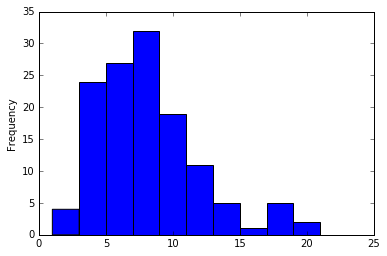

In [46]:
df['# of introns'].plot.hist()
plt.show()

### record if the host is longer than the rest

In [47]:
l = []
for i in range(df.shape[0]):
    sizes = np.asarray(df['Intron lengths'].values[i])
    
    ##recall host intron size is starts the list
    if sizes[0] == np.max(sizes):
        l.append('True')
    else:
        l.append('False')


In [48]:
df['Host is Longest?']=l

In [170]:
df['Host is Longest?'].value_counts()  

True     77
False    53
Name: Host is Longest?, dtype: int64

In [175]:
##some genes have multiple nested trnas
df.drop_duplicates(subset='Host_ID',keep='first')['Host is Longest?'].value_counts()  

True     43
False    22
Name: Host is Longest?, dtype: int64

In [181]:
43/65

0.6615384615384615

In [59]:
##soret both tables so that in same order
merged.sort_values(by='Host_Exon_ID',inplace=True)
df.sort_values('Host_ID',inplace=True)

In [55]:
df.head(3)

,Host_ID,# of introns,Intron lengths,GC-content,Host is Longest?
0,FBtr0071578,4,"[1272, 4264, 59, 74]","[0.46226415094339623, 0.4803001876172608, 0.28...",False
1,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False
2,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False


In [54]:
merged.head(3)

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,...,Intron_Sequence,A-content,G-content,T-content,C-content,tRNA_Sequence,A-content_trna,G-content_trna,T-content_trna,C-content_trna
128,2R,21181284,21181355,+,FBgn0053539,Trp-CCA-2-5-,FBtr0071578,1272,1625,Pu,...,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...,0.278302,0.225629,0.259434,0.236635,GACUCCGUGGCGCAACGGUAGCGCGUCCGACUCCAGAUCGGAAGGU...,0.194444,0.333333,0.194444,0.277778
104,3L,3096369,3096440,+,FBgn0052287,Cys-GCA-1-3-,FBtr0073124,2776,3953,Cht7,...,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282,GGGGAUAUAGCUCAGUGGUAGAGCAUUCGACUGCAGAUCGAGAGGU...,0.208333,0.319444,0.208333,0.263889
103,3L,3097519,3097590,+,FBgn0052286,Cys-GCA-1-4-,FBtr0073124,2776,3953,Cht7,...,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282,GGGGAUAUAGCUCAGUGGUAGAGCAUUCGACUGCAGAUCGAGAGGU...,0.208333,0.319444,0.208333,0.263889


## Do introns hosts tRNAs because they are longer:

Check host being the longest intron is related to co-orientation for host genes with more than one intron.

In [60]:
merged['Longest?']=df['Host is Longest?'].values

In [82]:
merged['Number of Introns'] = df['# of introns'].values

In [83]:
multi = merged[merged['Number of Introns']>1] ##extract genes with multiple introns

In [84]:
multi[multi['Co-orientation']=='Yes']['Longest?'].value_counts()

True     33
False    18
Name: Longest?, dtype: int64

In [85]:
multi[multi['Co-orientation']=='No']['Longest?'].value_counts()

True     42
False    35
Name: Longest?, dtype: int64

In [86]:
multi[multi['Co-orientation']=='Yes']['Longest?'].value_counts().to_frame().reset_index()

,index,Longest?
0,True,33
1,False,18


In [91]:
s = multi[multi['Co-orientation']=='Yes']['Longest?'].value_counts().to_frame().reset_index()
s.columns=['Longest','Number of Host']
s['Orientation']='Sense'
a = multi[multi['Co-orientation']=='No']['Longest?'].value_counts().reset_index()
a.columns=['Longest','Number of Host']
a['Orientation']='Antisense'
X= pd.concat([s,a],axis=0)
X

,Longest,Number of Host,Orientation
0,True,33,Sense
1,False,18,Sense
0,True,42,Antisense
1,False,35,Antisense


### relatively the host introns that are co-oriented with their nested trnas tend to be the longest introns of multi-exonic genes


In [89]:
"compute odds ratio of sense introns being the longest of multiexonic host gene than the antisene"
probs_sense = 33/18 ##number of sense longest introns/number of notlongest sense introns
probs_anti = 42/35  ##number of antisense longest introns/number of notlongest antisense introns
odds = probs_sense/probs_anti
odds

1.5277777777777777

or with scipy.stats

In [105]:
y = pd.concat([s, a], axis = 1, keys=(list('AB')))
y

A                                  B                           
  Longest Number of Host Orientation Longest Number of Host Orientation
0    True             33       Sense    True             42   Antisense
1   False             18       Sense   False             35   Antisense

In [106]:
con_table = y.groupby(level=0).sum().values
con_table

array([[33, 42],
       [18, 35]], dtype=int64)

In [107]:
oddsratio, pvalue = stats.fisher_exact(con_table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  1.5277777777777777 p-Value: 0.2763994988606483


Host introns that are sense to their nested tRNAs are 1.5times as likely to be the longest intron within the gene

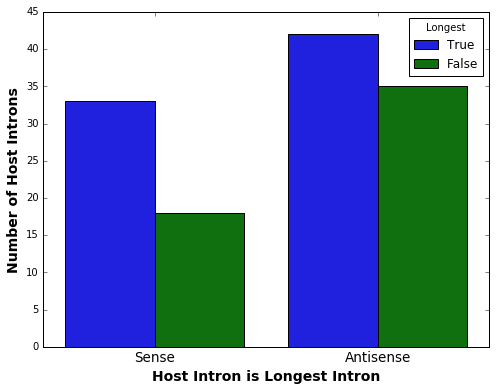

In [88]:
plt.figure(figsize=(8,6))
seaborn.barplot(x='Orientation', y='Number of Host', data=X, hue='Longest')
plt.ylabel('Number of Host Introns',fontsize=14,fontweight='bold')
plt.xlabel('Host Intron is Longest Intron',fontsize=14,fontweight='bold');plt.xticks(fontsize=13.5)
plt.show()

### Compare GC-content: since the tRNAs are mostly GC-rich, are their host introns more GC rich too
- shit I should removed the trna sequences

In [108]:
df.head()

,Host_ID,# of introns,Intron lengths,GC-content,Host is Longest?
0,FBtr0071578,4,"[1272, 4264, 59, 74]","[0.46226415094339623, 0.4803001876172608, 0.28...",False
1,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False
2,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False
3,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False
4,FBtr0073124,7,"[2776, 70, 64, 60, 8929, 62, 60]","[0.3868876080691642, 0.41428571428571426, 0.34...",False


In [111]:
l = []
for i in range(df.shape[0]):
    sizes = np.asarray(df['GC-content'].values[i])
    
    ##recall host intron GC is starts the list
    if sizes[0] == np.max(sizes):
        l.append('True')
    else:
        l.append('False')
df['Host_intron GC highest']=l
merged['GC_highest?']=l

In [113]:
multi = merged[merged['Number of Introns']>1] ##extract genes with multiple introns
s = multi[multi['Co-orientation']=='Yes']['GC_highest?'].value_counts().to_frame().reset_index()
s.columns=['GC_highest','Number of Host']
s['Orientation']='Sense'
a = multi[multi['Co-orientation']=='No']['GC_highest?'].value_counts().reset_index()
a.columns=['GC_highest','Number of Host']
a['Orientation']='Antisense'
G= pd.concat([s,a],axis=0)
G

,GC_highest,Number of Host,Orientation
0,False,44,Sense
1,True,7,Sense
0,False,56,Antisense
1,True,21,Antisense


In [114]:
##odds ratio again
con_table2 = pd.concat([s, a], axis = 1, keys=(list('AB'))).groupby(level=0).sum().values
oddsratio, pvalue = stats.fisher_exact(con_table2)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  2.357142857142857 p-Value: 0.08280668438540337


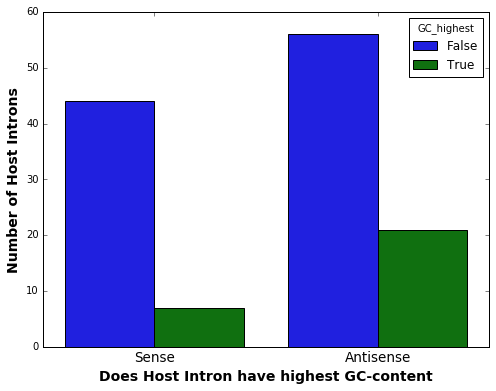

In [116]:
plt.figure(figsize=(8,6))
seaborn.barplot(x='Orientation', y='Number of Host', data=G, hue='GC_highest')
plt.ylabel('Number of Host Introns',fontsize=14,fontweight='bold')
plt.xlabel('Does Host Intron have highest GC-content',fontsize=14,fontweight='bold');plt.xticks(fontsize=13.5)
plt.show()

In [125]:
##mean GC content and sd without considering the host intron
m = []
sd=[]
for i in range(df.shape[0]):
    sizes = np.asarray(df['GC-content'].values[i][1:])
    if len(sizes)==0:
        continue
    else:
        m.append(np.mean(sizes))
        sd.append(np.std(sizes))

In [137]:
##mean GC content and sd including considering the host intron
m2 = []
sd2=[]
for i in range(df.shape[0]):
    sizes = np.asarray(df['GC-content'].values[i])
    if len(sizes)==1:
        continue
    else:
        
        m2.append(np.mean(sizes))
        sd2.append(np.std(sizes))

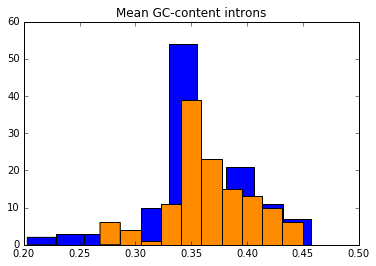

In [138]:
plt.hist(m) #mean GC without host intron GC contribution
plt.hist(m2,color='darkorange')  #mean GC with host intron GC contribution
plt.title('Mean GC-content introns')
plt.show()

either way nested tRNA nucleotide composition doesn't reflect their host introns, nor the neighbouring introns

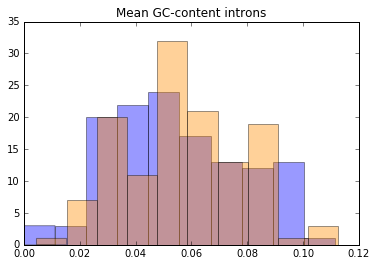

In [139]:
plt.hist(sd,alpha=0.4) #std GC without host intron GC contribution
plt.hist(sd2,color='darkorange',alpha=0.4)  #std GC with host intron GC contribution
plt.title('Mean GC-content introns')
plt.show()

In [135]:
from scipy.stats import pearsonr

In [140]:
pearsonr(m,m2)

(0.9784580117779015, 3.355793078570785e-88)

In [150]:
merged['AT-content_trna'] = merged['A-content_trna']+merged['T-content_trna']
merged['AT-content_intron']= merged['T-content']+merged['T-content']
merged['GC-content_trna'] = merged['G-content_trna']+merged['C-content_trna']
merged['GC-content_intron']= merged['G-content']+merged['C-content']

In [151]:
multi = merged[merged['Number of Introns']>1] ##extract genes with multiple introns
multi.shape

(128, 29)

In [155]:
##mean GC content and sd without considering the host intron
m = []
sd=[]
for i in range(df[df['# of introns']>1].shape[0]):
    sizes = np.asarray(df['GC-content'].values[i])
    m.append(np.mean(sizes))
    sd.append(np.std(sizes))
multi['Mean_GC_non_host_introns'] = m

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [153]:
multi.columns

Index(['Chrom', 'Start', 'End', 'Strand', 'tRNA_ID', 'tRNA_name',
       'Host_Exon_ID', 'intron_length', 'mRNA_length', 'Host_gene_name',
       'Host_Gene_Strand', 'Co-orientation', 'Intron_Sequence', 'A-content',
       'G-content', 'T-content', 'C-content', 'tRNA_Sequence',
       'A-content_trna', 'G-content_trna', 'T-content_trna', 'C-content_trna',
       'Longest?', 'Number of Introns', 'GC_highest?', 'AT-content_trna',
       'AT-content_intron', 'GC-content_trna', 'GC-content_intron',
       'Mean_Intron_gc'],
      dtype='object')

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

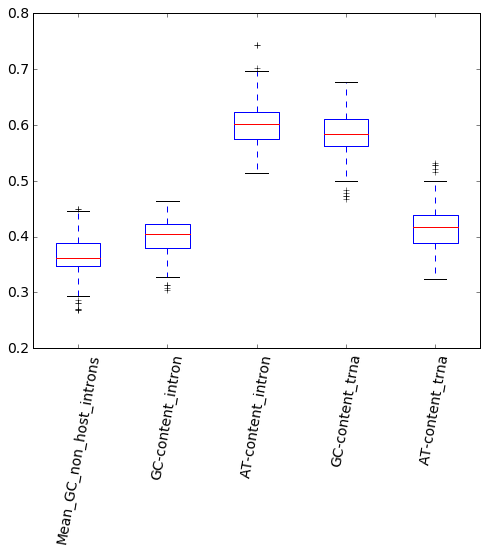

In [169]:
plt.figure(figsize=(8,6))
multi[['Mean_GC_non_host_introns','GC-content_intron','AT-content_intron','GC-content_trna',
        'AT-content_trna']].boxplot(grid=False,fontsize=14,rot=80)
#locs, labels = xticks()
plt.xticks(('Mean_GC_non_host_introns','GC-content_host_intron','AT-content_host_intron','GC-content_trna',
        'AT-content_trna'))
plt.show()

AGAIN nested tRNA nucleotide composition doesn't reflect their host introns, nor the neighbouring introns. Drosophila melanogaster introns are AT rich

### Are there cases where host intron is the shortest among introns?

In [176]:
l = []
for i in range(df.shape[0]):
    sizes = np.asarray(df['Intron lengths'].values[i])
    
    ##recall host intron size is starts the list
    if sizes[0] == np.min(sizes):
        l.append('True')
    else:
        l.append('False')
df['Host_intron is shortest']=l

In [177]:
df['Host_intron is shortest'].value_counts()  

False    128
True       2
Name: Host_intron is shortest, dtype: int64

In [178]:
###recall that one of the genes has only one intron
merged['Shortest?']=df['Host_intron is shortest'].values
multi = merged[merged['Number of Introns']>1] ##extract genes with multiple introns
multi['Shortest?'].value_counts()

False    128
Name: Shortest?, dtype: int64

In [ ]:
mult